## Code for lstm network development. data preparation for lstm can be found in preprocess/seqdata.ipynb

In [1]:
import sys,os
sys.path.append('/home/arash/ProjectVR/')
from preprocess import Seqdata    #import seqdata.py file
import numpy as np
import pandas as pd
import time
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Input, Embedding, Masking, Dropout
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K
from math import ceil, sqrt
import random
import glob,os
import matplotlib.pyplot as plt
import pickle
#import pdb
import shap
#from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
# from sklearn.base import BaseEstimator
# from sklearn.model_selection import GridSearchCV
#from sklearn.externals import joblib
#import joblib
import seaborn as sns
import matplotlib.animation as animation

import talos as ta

Using TensorFlow backend.
/home/arash/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/arash/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/arash/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/arash/anaco

### Load Data

In [2]:
# Loading files from drive
folder = '/home/arash/ProjectVR/cleaneddata/seqdata/'

#train set:

with open(f'{folder}XscaledTrain', 'rb') as f:
     XscaledTrain = pickle.load(f)

with open(f'{folder}YscaledTrain', 'rb') as f:
     YscaledTrain = pickle.load(f)

with open(f'{folder}distscaledTrain', 'rb') as f:
    distscaledTrain = pickle.load(f)

with open(f'{folder}usero1trajTrain', 'rb') as f:
     usero1trajTrain = pickle.load(f)

with open(f'{folder}usero2trajTrain', 'rb') as f:
     usero2trajTrain = pickle.load(f)

with open(f'{folder}usero3trajTrain', 'rb') as f:
     usero3trajTrain = pickle.load(f)
        
with open(f'{folder}userauxTrain', 'rb') as f:
     userauxTrain = pickle.load(f)

#test set:

with open(f'{folder}XscaledTest', 'rb') as f:
     XscaledTest = pickle.load(f)

with open(f'{folder}YscaledTest', 'rb') as f:
     YscaledTest = pickle.load(f)

with open(f'{folder}distscaledTest', 'rb') as f:
    distscaledTest = pickle.load(f)

with open(f'{folder}usero1trajTest', 'rb') as f:
     usero1trajTest = pickle.load(f)

with open(f'{folder}usero2trajTest', 'rb') as f:
     usero2trajTest = pickle.load(f)

with open(f'{folder}usero3trajTest', 'rb') as f:
     usero3trajTest = pickle.load(f)
        
with open(f'{folder}userauxTest', 'rb') as f:
     userauxTest = pickle.load(f)

### Define Vanilla Model

In [3]:
# Hypter Parameter dict
p = {"Llayers" : [1,2,3],
      "nodes" : [10,50,100],
      "batch_size": [32,128]}

# Define custom metric

def score(y_true, y_pred):
    return -K.mean(K.square(y_pred - y_true))

def VanillaLSTM(X_t,Out_t,X_val,Out_val,params):

    n_features = X_t.shape[2] - 1
    n_steps_in = X_t.shape[1]
    n_steps_out = Out_t.shape[1]
    
    Llayers = params['Llayers']
    nodes = params['nodes']
    batch_size = params['batch_size']

    
    model = Sequential()
    model.add(Masking(mask_value=-0.01, input_shape=(n_steps_in, n_features)))
    
    for i in range(Llayers-1):
        model.add(LSTM(nodes, activation='relu',
                       return_sequences=True))
        
    model.add(LSTM(nodes, activation='relu'))
    model.add(Dense(n_steps_out))


    model.compile(optimizer='adam', loss='mse', metrics = [score])
    
    X_t = X_t[:,:,:n_features]
    X_val = X_val[:,:,:n_features]
    Out_t = Out_t[:,:,0] # 0 is index for X
    Out_val = Out_val[:,:,0]
    
    start = time.time()
    history = model.fit(X_t, Out_t,
                        validation_data=[X_val, Out_val],
                        epochs = 1, verbose = 100,
                        batch_size = batch_size)
    end = time.time()

    #print (f"Finished Fitting Model.\n Time Taken : {end - start} secs")
    
    return history, model

# Evaluate the model and predict
def RMSEerror(inputseq,Out):
    maxXY=654.9
    minXY=650.1
    n_features = inputseq.shape[2] - 1
    inputseq = inputseq[:,:,:n_features]
    Out = Out[:,:,0] # 0 is index for X

    Out_pred = VLSTM_object.best_model(metric = 'val_score').predict(inputseq)
    
    outinv = np.zeros(Out.shape)
    outpredinv = np.zeros(Out_pred.shape)
    for i in range(len(Out)):
        pos = sum (n>=0 for n in Out[i])     #position of the last actual value on y, not padded
        outinv[i][:pos]= Out[i][:pos] * (maxXY-minXY) + minXY
        outpredinv[i][:pos] = Out_pred[i][:pos]* (maxXY-minXY) + minXY

    RMSEerror = sqrt(mean_squared_error(outpredinv, outinv))    #negative of RMSE

    return RMSEerror


In [6]:
AllVLSTM = pd.DataFrame()
#data prepare
for Dtype in ['L_3','L_5','L_7',
             'T_1_1','T_1_2','T_2_1']:
    
    print (f'Scanning VLSTM for {Dtype}:')
    funclean = Seqdata.PrepareData(dtype = Dtype)
    inputseqTrain, outTrain = funclean.run(XscaledTrain,YscaledTrain,
                                           distscaledTrain,usero1trajTrain,
                                           usero2trajTrain,usero3trajTrain,
                                           userauxTrain)

    inputseqTest, outTest = funclean.run(XscaledTest,YscaledTest,
                                         distscaledTest,usero1trajTest,
                                         usero2trajTest,usero3trajTest,
                                         userauxTest)
   
    
    VLSTM_object = ta.Scan(x = inputseqTrain,
                           y = outTrain, 
                           params = p,
                           model = VanillaLSTM,
                           val_split = 0.2,
                           experiment_name=f'VLSTM{Dtype}')
    
    datadf = VLSTM_object.data
    datadf['Dtype'] = Dtype
    AllVLSTM = AllVLSTM.append(datadf)
    
    #TestError = RMSEerror(inputseqTest,outTest)
#     analyze_object = ta.Analyze(VLSTM_object)
#     bestparams = analyze_object.best_params(
#         'val_score', ['round_epochs', 'loss',
#                       'val_loss','score'])[0][:3]
    


Scanning VLSTM for L_3:
3261
Scanning VLSTM for L_5:
3261
Scanning VLSTM for L_7:
3261
Scanning VLSTM for T_1_1:
58620
Scanning VLSTM for T_1_2:
32455
Scanning VLSTM for T_2_1:
32455


In [ ]:
AllVLSTM.to_csv('HyperParam_VLSTM.csv',index = False)

In [ ]:
AllVLSTM.sort_values(by = 'val_score',ascending = False)

In [ ]:
# use Scan object as input
analyze_object = ta.Analyze(VLSTM_object)

In [ ]:
# access the dataframe with the results
analyze_object.data

In [ ]:
# get the highest score
analyze_object.high('val_score')

In [ ]:
analyze_object.best_params('val_score', ['round_epochs', 'loss', 'val_loss','score'])[0][:3]

In [ ]:
# get correlation for hyperparameters against a metric
analyze_object.correlate('val_loss', ['val_acc','loss', 'val_loss'])

In [ ]:
# line plot
analyze_object.plot_line('val_acc')

In [ ]:
# up to two dimensional kernel density estimator
analyze_object.plot_kde('val_acc')

In [ ]:
# get correlation for hyperparameters against a metric
analyze_object.correlate('val_loss', ['val_acc', 'loss', 'val_loss'])

In [ ]:
# heatmap correlation
analyze_object.plot_corr('val_loss', ['val_acc', 'loss', 'val_loss'])

In [ ]:
# a four dimensional bar grid
analyze_object.plot_bars('batch_size', 'val_acc', 'nodes', 'Llayers')

In [ ]:
# class VanillaLSTM(BaseEstimator):
    
#     def __init__(self, nodes=50, batch_size=128,
#                  epochs=200, Llayers=1, features=6, steps_in=0, steps_out=0
#                  ):

#         self.nodes = nodes
#         self.batch_size = batch_size
#         self.epochs = epochs
#         self.Llayers= Llayers
#         self.features = features
#         self.steps_in = steps_in
#         self.steps_out = steps_out
#         self.maxXY=654.9
#         self.minXY=650.1


#     def create_model(self):
#         model = Sequential()
#         model.add(Masking(mask_value=-0.01, input_shape=(self.steps_in, self.features)))
#         for i in range(self.Llayers-1):
#             model.add(LSTM(self.nodes, activation='relu', return_sequences=True))
#         model.add(LSTM(self.nodes, activation='relu'))
#         model.add(Dense(self.steps_out))
#         model.compile(optimizer='adam', loss='mse')
#         return model
    
#     def fit(self,inputseq,out):
#         start = time.time()
#         X = inputseq[:,:,:self.features]
#         out = out[:,:,0] # 0 is index for X
#         self.model=self.create_model()
#         self.model.fit(X, out, epochs = self.epochs, verbose = 100, batch_size = self.batch_size)
#         end = time.time()
#         print ("Finished Fitting Model. # of Epochs: %d\n Time Taken : %d secs"
#                % (self.epochs,end - start))
#         return self
    
#     def predict(self, inputseq):
#         X = inputseq[:,:,:self.features]
        
#         return self.model.predict(X)
    
#     def score(self,inputseq,out):
        
#         X = inputseq[:,:,:self.features]
#         outpred = self.predict(X)
#         out = out[:,:,0]
#         outinv = np.zeros(out.shape)
#         outpredinv = np.zeros(outpred.shape)
#         for i in range(len(out)):
#             pos = sum (n>=0 for n in out[i])     #position of the last actual value on y, not padded
#             outinv[i][:pos]= out[i][:pos] * (self.maxXY-self.minXY) + self.minXY
#             outpredinv[i][:pos] = outpred[i][:pos]* (self.maxXY-self.minXY) + self.minXY
            
#         rmseScore = -sqrt(mean_squared_error(outpredinv, outinv))    #negative of RMSE

#         return rmseScore
        

### fitting Vanilla LSTM, using grid search for hypperparameters

In [ ]:
# n_features = inpTrain.shape[2] - 1
# n_steps_in = inpTrain.shape[1]
# n_steps_out = outTrain.shape[1]

# VLmodel=VanillaLSTM(epochs=200, features=n_features,
#                     steps_in=n_steps_in, steps_out=n_steps_out)

In [ ]:
# tuned_params = {"Llayers" : [1,2],"nodes" : [10,50]}#,"batch_size": [128]}

#gs = GridSearchCV(VLmodel, tuned_params,cv = 8, refit= True, n_jobs=-1,verbose = 100)

In [ ]:
#np.load('/home/arash/ProjectVR/models/trainedmodels/VLSTM1.pkl',allow_pickle=True)      
# outTrain.shape

In [ ]:
# grid_result = gs.fit(inpTrain,outTrain)

In [ ]:
# np.save(f'/home/arash/ProjectVR/models/GridResults/VLSTM200_8{dtype}.npy',grid_result.cv_results_)      
#filename: ModelnameEpochs_CV_data type

In [ ]:
# bestVLSTM = grid_result.best_estimator_

In [ ]:
# joblib.dump(bestVLSTM, '/home/arash/ProjectVR/models/trainedmodels/VLSTM1.pkl')

In [ ]:
# bestVLSTM.score(inpTest,outTest)

# bestVLSTM.score(inpTest,outTest)

# VLmodel.fit(inpTrain,outTrain)

# VLmodel.score(inpTEST,outTest)

In [ ]:
# history = bestVLSTM.model.history.history
# # plot history
# plt.plot(history['loss'], label='train')
# #pyplot.plot(history.history['val_loss'], label='test')
# plt.legend()
# plt.show()


## lstm model with aux variables

In [6]:
p = {"Llayers" : [2],
     "Dlayers" : [3],
     "nodes" : [100],
     "batch_size": [32], 
     "drpout" : [0]}

def AuxLSTM(X_t,Out_t,X_val,Out_val,params):
    n_features = X_t.shape[2] - 1
    aux_size = sum(X_t[:,:,n_features][0]!=-0.01)
    n_steps_in = X_t.shape[1]
    n_steps_out = Out_t.shape[1]
    
    Llayers = params['Llayers']
    Dlayers = params['Dlayers']
    drpout = params['drpout']
    nodes = params['nodes']
    batch_size = params['batch_size']

    
    seq_input = Input(shape=(n_steps_in, n_features), dtype='float32', name='seq_input')
    mask = Masking(mask_value=-0.01)(seq_input)
    
    if Llayers==1:
        lstm_out = LSTM(nodes, activation='relu')(mask)
        
    else:
        lstm_out = LSTM(nodes,activation='relu',return_sequences=True)(mask)
        for i in range(Llayers-2):
            lstm_out = LSTM(nodes,activation='relu',return_sequences=True)(lstm_out)
        lstm_out = LSTM(nodes, activation='relu')(lstm_out)

    #output for lstm, corresponds to 0.2 of loss, used to smooth training and regularization:
    sec_output = Dense(n_steps_out, activation='sigmoid' ,name='sec_output')(lstm_out)   

    auxiliary_input = Input(shape=(aux_size,), name='aux_input')
    

    mrgLayer = keras.layers.concatenate([lstm_out, auxiliary_input])

    # We stack a deep densely-connected network on top
    for i in range(Dlayers):
        mrgLayer = Dense(nodes, activation='relu')(mrgLayer)
        if drpout>0:
            mrgLayer = Dropout(drpout)(mrgLayer)

    # And finally we add the main logistic regression layer
    main_output = Dense(n_steps_out, activation='sigmoid', name='main_output')(mrgLayer)

    modelaux = Model(inputs=[seq_input, auxiliary_input], outputs=[main_output, sec_output])


    modelaux.compile(optimizer='adam', loss='mse', metrics = [score],
              loss_weights=[1., 0.2])
    
    
    aux_t = X_t[:,:,n_features][:,-aux_size:]
    aux_val = X_val[:,:,n_features][:,-aux_size:]
    
    X_t = X_t[:,:,:n_features]
    X_val = X_val[:,:,:n_features]
    
    
    Out_t = Out_t[:,:,0] # 0 is index for X
    Out_val = Out_val[:,:,0]
    
    #start = time.time()
    history = modelaux.fit([X_t,aux_t], [Out_t,Out_t], 
                        validation_data = [[X_val, aux_val],[Out_val,Out_val]],
                        epochs = 100,
                        verbose = 10, 
                        batch_size = batch_size)
    
    #end = time.time()

    #print (f"Finished Fitting Model.\n Time Taken : {end - start} secs")
    
    return history, modelaux

# Evaluate the model and predict
def RMSEerror(inputseq,Out):
    maxXY=654.9
    minXY=650.1
    n_features = inputseq.shape[2] - 1
    aux_size = sum(inputseq[:,:,n_features][0]!=-0.01)
    aux = inputseq[:,:,n_features][:,-aux_size:]
    
    inputseq = inputseq[:,:,:n_features]
    
    Out = Out[:,:,0] # 0 is index for X

    Out_pred = AuxLSTM_object.best_model(
        metric = 'val_main_output_score').predict([inputseq,aux])[0]
    
    outinv = np.zeros(Out.shape)
    outpredinv = np.zeros(Out_pred.shape)
    for i in range(len(Out)):
        pos = sum (n>=0 for n in Out[i])     #position of the last actual value on y, not padded
        outinv[i][:pos]= Out[i][:pos] * (maxXY-minXY) + minXY
        outpredinv[i][:pos] = Out_pred[i][:pos]* (maxXY-minXY) + minXY

    RMSEerror = sqrt(mean_squared_error(outpredinv, outinv))    #negative of RMSE

    return RMSEerror

In [44]:
RMSEerror(inputseqTrain,outTrain)

0.09925822592507867

In [7]:
#### T_1_1
def score(y_true, y_pred):
    return -K.mean(K.square(y_pred - y_true))

AllAuxLSTM = pd.DataFrame()
#data prepare
for Dtype in ['T_1_1']:
    
    print (f'Scanning AuxLSTM for {Dtype}:')
    funclean = Seqdata.PrepareData(dtype = Dtype)
    inputseqTrain, outTrain = funclean.run(XscaledTrain,YscaledTrain,
                                           distscaledTrain,usero1trajTrain,
                                           usero2trajTrain,usero3trajTrain,
                                           userauxTrain)

    inputseqTest, outTest = funclean.run(XscaledTest,YscaledTest,
                                         distscaledTest,usero1trajTest,
                                         usero2trajTest,usero3trajTest,
                                         userauxTest)
    
    AuxLSTM_object = ta.Scan(x = inputseqTrain,
                           y = outTrain, 
                           params = p,
                           model = AuxLSTM,
                           val_split = 0.2,
                           experiment_name=f'AuxLSTM{Dtype}')
    
    datadf = AuxLSTM_object.data
    datadf['Dtype'] = Dtype
    AllAuxLSTM = AllAuxLSTM.append(datadf)



Scanning AuxLSTM for T_1_1:



  0%|          | 0/1 [00:00<?, ?it/s]

Train on 37528 samples, validate on 9382 samples
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/10


100%|██████████| 1/1 [22:00<00:00, 1320.56s/it]


In [ ]:
bestm = AuxLSTM_object.best_model(
        metric = 'val_main_output_score')
# Evaluate the model and predict
funclean = Seqdata.PrepareData(dtype = 'T_1_1')

inputseqTrain, outTrain = funclean.run(XscaledTrain,YscaledTrain,
                                       distscaledTrain,usero1trajTrain,
                                       usero2trajTrain,usero3trajTrain,
                                       userauxTrain)

inputseqTest, outTest = funclean.run(XscaledTest,YscaledTest,
                                     distscaledTest,usero1trajTest,
                                     usero2trajTest,usero3trajTest,
                                     userauxTest)


n_features = 6
aux_size = 14
aux = inputseqTrain[:,:,n_features][:,-aux_size:]
inputseq = inputseqTrain[:,:,:n_features][0].reshape(1,14,6)
Out = outTrain[:,:,0][0].reshape(1,10) # 0 is index for X

In [84]:
def pred(aux):
    maxXY=654.9
    minXY=650.1

    Out_pred = bestm.predict([inputseq,np.array(aux).reshape(1,14)])[0]
    
    outinv = np.zeros(Out.shape)
    outpredinv = np.zeros(Out_pred.shape)
    #for i in range(len(Out)):
    pos = 10     #position of the last actual value on y, not padded
    outinv[:pos]= Out[:pos] * (maxXY-minXY) + minXY
    outpredinv[:pos] = Out_pred[:pos]* (maxXY-minXY) + minXY

    RMSEerror = sqrt(mean_squared_error(outpredinv, outinv))   
    y = np.array([RMSEerror])

    return y

def f(X):
    pr = []
    for i in range(X.shape[0]):
        pr.append(pred([X[i,:]]))
    return np.array(pr).flatten()

#ss = f(aux[1:3])

### Interpretability

#using train set for interpretability
dfxtrain = pd.DataFrame(aux)
dfxtrain.columns=dfxtrain.columns=['Snowy','Night', 'One way', 'two way', 'Two way with median',
                 'Speed Limit_30.0', 'Speed Limit_40.0', 'Speed Limit_50.0',
                 'Lane Width_2.5', 'Lane Width_2.75', 'Lane Width_3.0',
                 'Mean Arrival Rate_530.0', 'Mean Arrival Rate_750.0',
                 'Mean Arrival Rate_1100.0']

#pred(dfxtrain)
#yp = pred(inputseqTrain,outTrain)

In [27]:
#using zeros as background data for binary variables, and mean value for cont variables
backgrounddata = pd.DataFrame(np.zeros(14)).T  
backgrounddata.columns = dfxtrain.columns





#data = dfxtrain.iloc[np.random.choice(np.arange(len(dfxtrain)), 10, False)]


explainer = shap.KernelExplainer(f,backgrounddata)

shap_values = explainer.shap_values(dfxtrain)

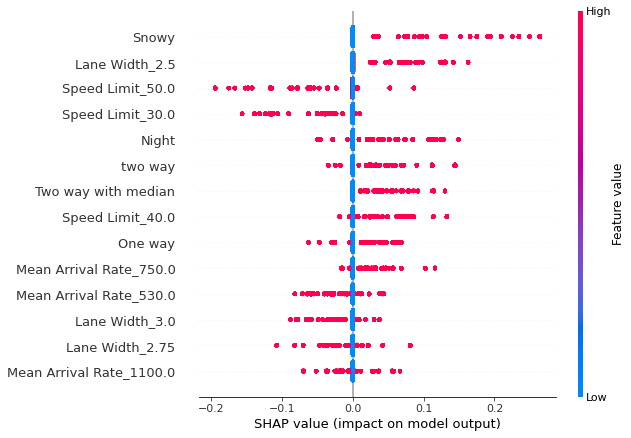

In [30]:
fig = shap.summary_plot(shap_values, dfxtrain,max_display=20,show =False)
plt.savefig('shaptraj', bbox_inches='tight')

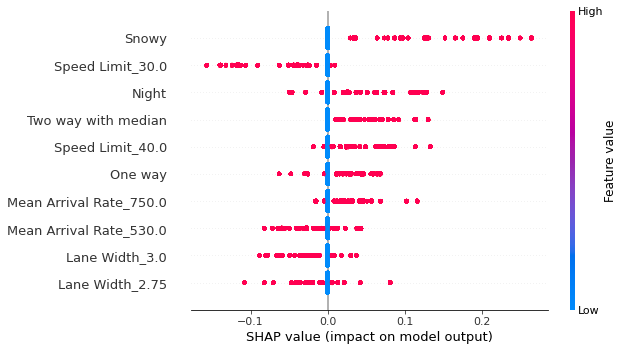

In [41]:
modifSHAP = pd.DataFrame(shap_values)
modifSHAP.columns = dfxtrain.columns
modifSHAP = modifSHAP.drop(columns = ['Lane Width_2.5','Speed Limit_50.0',
                          'two way','Mean Arrival Rate_1100.0'])

modifdfxtrain = dfxtrain.drop(columns = ['Lane Width_2.5','Speed Limit_50.0',
                          'two way','Mean Arrival Rate_1100.0'])

fig2 = shap.summary_plot(np.array(modifSHAP), modifdfxtrain,max_display=20,show =False)
plt.savefig('shaptraj2', bbox_inches='tight')

In [89]:
#### t12
p = {"Llayers" : [3],
     "Dlayers" : [1],
     "nodes" : [50],
     "batch_size": [32], 
     "drpout" : [0]}
def score(y_true, y_pred):
    return -K.mean(K.square(y_pred - y_true))

#AllAuxLSTM = pd.DataFrame()
#data prepare
for Dtype in ['T_1_2']:
    
    print (f'Scanning AuxLSTM for {Dtype}:')
    funclean = Seqdata.PrepareData(dtype = Dtype)
    inputseqTrain, outTrain = funclean.run(XscaledTrain,YscaledTrain,
                                           distscaledTrain,usero1trajTrain,
                                           usero2trajTrain,usero3trajTrain,
                                           userauxTrain)

    inputseqTest, outTest = funclean.run(XscaledTest,YscaledTest,
                                         distscaledTest,usero1trajTest,
                                         usero2trajTest,usero3trajTest,
                                         userauxTest)
    
    AuxLSTM_object12 = ta.Scan(x = inputseqTrain,
                           y = outTrain, 
                           params = p,
                           model = AuxLSTM,
                           val_split = 0.2,
                           experiment_name=f'AuxLSTM{Dtype}')
    
    #datadf = AuxLSTM_object.data
    #datadf['Dtype'] = Dtype
    #AllAuxLSTM = AllAuxLSTM.append(datadf)



Scanning AuxLSTM for T_1_2:


In [90]:
bm = AuxLSTM_object12.best_model(
        metric = 'val_main_output_score')
def RMSEerror(inputseq,Out):
    maxXY=654.9
    minXY=650.1
    n_features = inputseq.shape[2] - 1
    aux_size = sum(inputseq[:,:,n_features][0]!=-0.01)
    aux = inputseq[:,:,n_features][:,-aux_size:]
    
    inputseq = inputseq[:,:,:n_features]
    
    Out = Out[:,:,0] # 0 is index for X

    Out_pred = bm.predict([inputseq,aux])[0]
    
    outinv = np.zeros(Out.shape)
    outpredinv = np.zeros(Out_pred.shape)
    for i in range(len(Out)):
        pos = sum (n>=0 for n in Out[i])     #position of the last actual value on y, not padded
        outinv[i][:pos]= Out[i][:pos] * (maxXY-minXY) + minXY
        outpredinv[i][:pos] = Out_pred[i][:pos]* (maxXY-minXY) + minXY

    RMSEerror = sqrt(mean_squared_error(outpredinv, outinv))    #negative of RMSE

    return RMSEerror
RMSEerror(inputseqTest,outTest)

0.5108666009025906

In [99]:

# Evaluate the model and predict
#funclean = Seqdata.PrepareData(dtype = 'T_1_1')

#inputseqTrain, outTrain = funclean.run(XscaledTrain,YscaledTrain,
#                                        distscaledTrain,usero1trajTrain,
#                                        usero2trajTrain,usero3trajTrain,
#                                        userauxTrain)

# inputseqTest, outTest = funclean.run(XscaledTest,YscaledTest,
#                                      distscaledTest,usero1trajTest,
#                                      usero2trajTest,usero3trajTest,
#                                      userauxTest)


n_features = 6
aux_size = 14
aux = inputseqTrain[:,:,n_features][:,-aux_size:]
inputseq = inputseqTrain[:,:,:n_features][0].reshape(1,14,6)
Out = outTrain[:,:,0][0].reshape(1,20) # 0 is index for X

In [103]:
def pred(aux):
    maxXY=654.9
    minXY=650.1

    Out_pred = bm.predict([inputseq,np.array(aux).reshape(1,14)])[0]
    
    outinv = np.zeros(Out.shape)
    outpredinv = np.zeros(Out_pred.shape)
    #for i in range(len(Out)):
    pos = 20     #position of the last actual value on y, not padded
    outinv[:pos]= Out[:pos] * (maxXY-minXY) + minXY
    outpredinv[:pos] = Out_pred[:pos]* (maxXY-minXY) + minXY

    RMSEerror = sqrt(mean_squared_error(outpredinv, outinv))   
    y = np.array([RMSEerror])

    return y

def f(X):
    pr = []
    for i in range(X.shape[0]):
        pr.append(pred([X[i,:]]))
    return np.array(pr).flatten()

#ss = f(aux[1:3])

### Interpretability

#using train set for interpretability
dfxtrain = pd.DataFrame(aux)
dfxtrain.columns=dfxtrain.columns=['Snowy','Night', 'One way', 'two way', 'Two way with median',
                 'Speed Limit_30.0', 'Speed Limit_40.0', 'Speed Limit_50.0',
                 'Lane Width_2.5', 'Lane Width_2.75', 'Lane Width_3.0',
                 'Mean Arrival Rate_530.0', 'Mean Arrival Rate_750.0',
                 'Mean Arrival Rate_1100.0']

#pred(dfxtrain)
#yp = pred(inputseqTrain,outTrain)

In [104]:
#using zeros as background data for binary variables, and mean value for cont variables
backgrounddata = pd.DataFrame(np.zeros(14)).T  
backgrounddata.columns = dfxtrain.columns





#data = dfxtrain.iloc[np.random.choice(np.arange(len(dfxtrain)), 10, False)]


explainer = shap.KernelExplainer(f,backgrounddata)

shap_values = explainer.shap_values(dfxtrain)

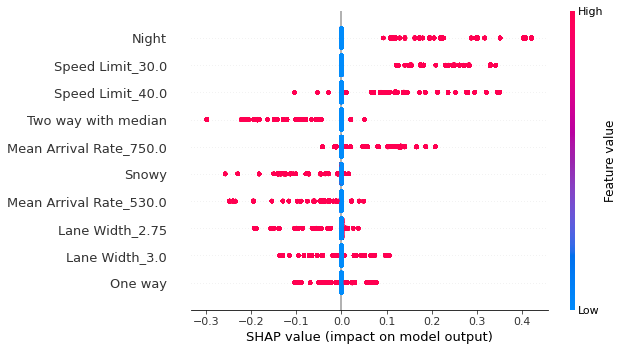

In [105]:
modifSHAP = pd.DataFrame(shap_values)
modifSHAP.columns = dfxtrain.columns
modifSHAP = modifSHAP.drop(columns = ['Lane Width_2.5','Speed Limit_50.0',
                          'two way','Mean Arrival Rate_1100.0'])

modifdfxtrain = dfxtrain.drop(columns = ['Lane Width_2.5','Speed Limit_50.0',
                          'two way','Mean Arrival Rate_1100.0'])

fig2 = shap.summary_plot(np.array(modifSHAP), modifdfxtrain,max_display=20,show =False)
plt.savefig('shaptraj3', bbox_inches='tight')

In [ ]:
AllAuxLSTM.to_csv('HyperParam_AuxLSTM.csv',index = False)

In [ ]:
AllAuxLSTM.sort_values(by = 'val_main_output_score',ascending = False)

In [ ]:
# class AuxLSTM(BaseEstimator):
    
#     def __init__(self, nodes=50, batch_size=32,
#                  epochs=200, Dlayers=1, Llayers=1, features=6, steps_in=0, steps_out=0, drpout=0.5
#                  ):

#         self.nodes = nodes
#         self.features = features
#         self.steps_in = steps_in
#         self.steps_out = steps_out
#         self.epochs = epochs
#         self.batch_size = batch_size
#         self.Dlayers= Dlayers   #number of hidden dense layers
#         self.Llayers = Llayers  #number of lstm layers
#         self.maxXY=654.9
#         self.minXY=650.1
#         self.drpout=drpout


#     def create_model(self):
        
#         seq_input = Input(shape=(self.steps_in, self.features), dtype='float32', name='seq_input')
#         mask = Masking(mask_value=-0.01)(seq_input)
#         if self.Llayers==1:
            
#             lstm_out = LSTM(self.nodes, activation='relu')(mask)
            
#         else:
#             lstm_out = LSTM(self.nodes,activation='relu',return_sequences=True)(mask)
            
#             for i in range(self.Llayers-2):
#                 lstm_out = LSTM(self.nodes,activation='relu',return_sequences=True)(lstm_out)
                
#             lstm_out = LSTM(self.nodes, activation='relu')(lstm_out)

#         #output for lstm, corresponds to 0.2 of loss, used to smooth training and regularization:
#         sec_output = Dense(self.steps_out, activation='sigmoid' ,name='sec_output')(lstm_out)   

#         auxiliary_input = Input(shape=(14,), name='aux_input')
        
#         x = keras.layers.concatenate([lstm_out, auxiliary_input])

#         # We stack a deep densely-connected network on top
#         for i in range(self.Dlayers):
#             x = Dense(self.nodes, activation='relu')(x)
#             if self.drpout>0:
#                 x = Dropout(self.drpout)(x)

#         # And finally we add the main logistic regression layer
#         main_output = Dense(self.steps_out, activation='sigmoid', name='main_output')(x)

#         modelaux = Model(inputs=[seq_input, auxiliary_input], outputs=[main_output, sec_output])


#         modelaux.compile(optimizer='adam', loss='mse',
#                       loss_weights=[1., 0.2])
#         return modelaux
    
#     def fit(self,inp,out):
#         start = time.time()
#         X = inp[:,:,:self.features]
#         aux = inp[:,:,self.features][:,-14:] 
#         out = out[:,:,0]
#         self.model = self.create_model()
#         self.model.fit([X,aux], [out,out], epochs = self.epochs, verbose = 100, batch_size = self.batch_size)
#         end = time.time()
#         print ("Finished Fitting AuxModel. # of Epochs: %d\n Time Taken : %d secs"
#                % (self.epochs,end - start))
#         return self
    
#     def predict(self, inp):
#         X = inp[:,:,:self.features]
#         aux = inp[:,:,self.features][:,-14:]
        
#         return self.model.predict([X,aux])
    
#     def score(self,inp,out):
#         out = out[:,:,0]
#         outpred = self.predict(inp)[0]        #auxlstm has two identical outputs, 1st in chosen
#         outinv = np.zeros(out.shape)
#         outpredinv = np.zeros(outpred.shape)
#         for i in range(len(out)):
#             pos = sum (n>=0 for n in out[i])    #position of the last actual value on y, not padded
#             outinv[i][:pos]= out[i][:pos] * (self.maxXY-self.minXY) + self.minXY
#             outpredinv[i][:pos] = outpred[i][:pos]* (self.maxXY-self.minXY) + self.minXY
            
#         rmseScore = -sqrt(mean_squared_error(outpredinv, outinv))    #negative of RMSE
#         return rmseScore
        

In [ ]:
# n_features = (inpTrain.shape[2]-1)
# n_steps_in = inpTrain.shape[1]
# n_steps_out = outTrain.shape[1]

# Auxmodel=AuxLSTM(epochs=100, features=n_features,
#                     steps_in=n_steps_in, steps_out=n_steps_out)
 

In [ ]:
# tuned_params = {"Dlayers" : [1,2]}#,'drpout': [0,0.5], "Llayers" : [2]}
#                # 'batch_size' : [64], 'nodes': [100]  }

# gsaux = GridSearchCV(Auxmodel, tuned_params,cv = 5, refit= True, n_jobs=-1)

# gridaux_result = gsaux.fit(inpTrain,outTrain)

# gridaux_result.cv_results_

# bestauxLSTM = gridaux_result.best_estimator_

# bestauxLSTM.score(inpTest,outTest)

# np.save('/home/arash/ProjectVR/models/GridResults/Aux0_5LSTM001.npy',gridaux_result.cv_results_)
# bestauxLSTM = gridaux_result.best_estimator_

# joblib.dump(bestauxLSTM, '/home/arash/ProjectVR/models/trainedmodels/Aux0_5LSTM6.pkl')
# bestauxLSTM.score(inputseqTEST,ytest)

In [ ]:
# Aux1Best=AuxLSTM(epochs=1000, features=n_features,
#                     steps_in=n_steps_in, steps_out=n_steps_out,Llayers=2,Dlayers=1,drpout=0.5,
#                    batch_size=32, nodes=50)

# Aux2Best=AuxLSTM(epochs=100, features=n_features,
#                     steps_in=n_steps_in, steps_out=n_steps_out,Llayers=2,Dlayers=1,drpout=0.5,
#                    batch_size=32, nodes=50)

# Animation Creation

In [ ]:
bestaux=joblib.load('/home/arash/ProjectVR/models/trainedmodels/AuxLSTM2.pkl')

In [ ]:
bestvlstm=joblib.load('/home/arash/ProjectVR/models/trainedmodels/VLSTM1.pkl')

In [ ]:
bestaux.score(inputseqtrain,ytrain)

In [ ]:
bestaux0_5=joblib.load('/home/arash/ProjectVR/models/trainedmodels/Aux0_5LSTM6.pkl')

In [ ]:
maxXY=654.9
minXY=650.1

In [ ]:
num=1

In [ ]:
ypred = bestaux.predict(inputseqtrain)[0][num]        #auxlstm has two identical outputs, 1st in chosen
ypredvlstm=bestvlstm.predict(inputseqtrain)[num] 


pos = sum (n>=0 for n in ytrain[num])                #position of the last actual value on y, not padded

title= "X Coordinate"
y= ypred[:pos]* (maxXY-minXY) + minXY
x = np.arange(0,len(y)/10,0.1)
xv=x
yv=ypredvlstm[:pos]* (maxXY-minXY) + minXY

ytrue = ytrain[num][:pos] * (maxXY-minXY) + minXYnj
xtrue = x

In [ ]:
def augment(xold,yold,numsteps):
    xnew = []
    ynew = []
    for i in range(len(xold)-1):
        difX = xold[i+1]-xold[i]
        stepsX = difX/numsteps
        difY = yold[i+1]-yold[i]
        stepsY = difY/numsteps
        for s in range(numsteps):
            xnew = np.append(xnew,xold[i]+s*stepsX)
            ynew = np.append(ynew,yold[i]+s*stepsY)
    return xnew,ynew

In [ ]:
x,y=augment(x,y,10)
xv,yv=augment(xv,yv,10)
xtrue,ytrue=augment(xtrue,ytrue,10)


In [ ]:
true0=pd.DataFrame(ytrue,xtrue)
pred0=pd.DataFrame(y,x)
Vpred0=pd.DataFrame(yv,xv)
true0.columns = {title}

pred0.columns={title}
Vpred0.columns={title}

plt.rcParams['animation.ffmpeg_path'] = '/home/arash/anaconda3/envs/gpusupport/bin/ffmpeg'    

In [ ]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, metadata=dict(artist='Arash'), bitrate=1800)

In [ ]:
%matplotlib notebook
fig = plt.figure(figsize=(10,6))
plt.xlim(0, len(x)/100)
plt.ylim(np.min(pred0)[0], np.max(pred0)[0])
plt.xlabel('Time (s)',fontsize=14)
plt.ylabel(title,fontsize=14)
plt.title('Pedestrian Position Over Time',fontsize=14)
from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='g', lw=4),
                Line2D([0], [0], color='r', lw=4)]
plt.legend(custom_lines, ['AuxLSTM', 'True Trajectory', 'Vanilla LSTM'])

In [ ]:
def animate(i):
    dataaux = pred0.iloc[:int(i+1)] #select data range
    datatrue = true0.iloc[:int(i+1)] #select data range
    dataV=Vpred0.iloc[:int(i+1)] #select data range
    p = sns.lineplot(x=dataaux.index, y=dataaux[title], data=dataaux,markers=True,color="b")
    p2 = sns.lineplot(x=datatrue.index, y=datatrue[title], data=datatrue, markers=True,color="g")
    p3 = sns.lineplot(x=dataV.index, y=dataV[title], data=dataV, markers=True,color="r")
    sns.set_style("white")
    p.tick_params(labelsize=10)
    p2.tick_params(labelsize=10)
    p3.tick_params(labelsize=10)
    plt.setp(p.lines,linewidth=2)
    plt.setp(p2.lines,linewidth=2)

In [ ]:
ani = animation.FuncAnimation(fig, animate,frames=400 ,repeat=True)

ani.save('Sample03.mp4', writer=writer)

In [ ]:

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())






In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


In [ ]:
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))